# PJM Energy Consumption Dataset

This dataset contains data related to hourly level energy consumption in regions served by PJM Interconnection LLC (PJM). PJM Interconnection is a regional transmission organization (RTO) that coordinates the movement of wholesale electricity in all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (GW). This particular dataset is filtered to represent the time span from May 1st, 2017 through June 30th, 2018. There are ten regions represented in the data. This dataset is valuable for timeseries analysis at the hourly level. It contains seasonalities of different frequencies such as hour-of-day, day-of-week, and day-of-year. 

In [32]:
import pandas as pd
from typing import List, Tuple, Dict, Any
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os
import sys
import random
import matplotlib.pyplot as plt

In [33]:
dataset_name = "pjm_energy_consumption"

In [34]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

## Read Data 

In [35]:
file_names = [
    "AEP_hourly.csv",    # American Electric Power
    "COMED_hourly.csv",  # Commonwealth Edison
    "DAYTON_hourly.csv", # Dayton Power and Light 
    "DEOK_hourly.csv",   # Duke Energy Ohio/Kentucky
    "DOM_hourly.csv",    # Dominion Virginia
    "DUQ_hourly.csv",    # Duquesne Light Co
    "EKPC_hourly.csv",   # East Kentucky Power Cooperattive
    "FE_hourly.csv",     # First Energy
    "NI_hourly.csv",     # Northern Illinois Hub
    "PJME_hourly.csv",   # PJM East Region
    "PJMW_hourly.csv",   # PJM West Region
]

In [36]:
data = []

start_datetime = datetime.strptime("2017-05-01 00-00-00", '%Y-%m-%d %H-%M-%S')
end_datetime = datetime.strptime("2018-06-30 23-59-59", '%Y-%m-%d %H-%M-%S')

for file_ in file_names:
    df = pd.read_csv(os.path.join("./archive", file_), parse_dates=['Datetime'])
    df = df[(df["Datetime"]>=start_datetime) & (df["Datetime"]<=end_datetime)]
    if not df.empty: 
        print(df.shape)
        df.sort_values(by=["Datetime"], inplace=True)
        # insert a column with series name
        df.insert(0, "Region", file_.split("_")[0])
        # rename last column
        df.columns = [*df.columns[:-1], 'Energy_Consumption']
        data.append(df)
#         print(df.head())
#         sys.exit()

data = pd.concat(data)
print(data.shape)

(10224, 2)
(10224, 2)
(10224, 2)
(10224, 2)
(10224, 2)
(10224, 2)
(10224, 2)
(10224, 2)
(10224, 2)
(10224, 2)
(102240, 3)


## Convert Data to GW

In [37]:
# Energy consumption is in MW. Convert the units to GW 
data["Energy_Consumption_GW"] = data["Energy_Consumption"] / 1000.
data["Energy_Consumption_GW"] = data["Energy_Consumption_GW"].round(3)

## Drop Duplicates

In [38]:
# There are duplicate records for "11/5/2017  2:00:00 AM"
# Keeping the first and dropping the second
data.drop_duplicates(subset=["Region", "Datetime"], keep="first", inplace=True)

In [39]:
data["Datetime"].nunique()

10223

In [40]:
series_col = "Region"
epoch_col = "Datetime"
time_col = "Datetime"
value_col = 'Energy_Consumption_GW'
exog_cols = []

# Visualize

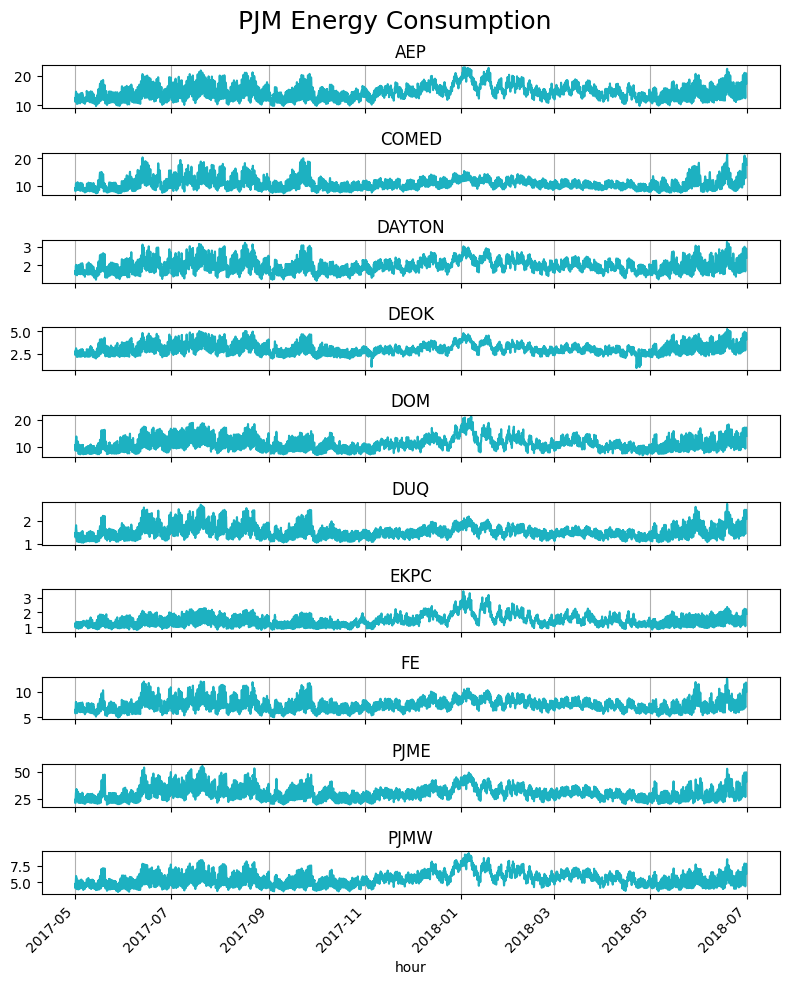

In [41]:
import matplotlib.pyplot as plt

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_trends(
    data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=epoch_col,
    epoch_label='hour',
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="PJM Energy Consumption"
)  


In [42]:
def fill_missing_timestamps(df: pd.DataFrame, index_col, freq='H', fill_method='ffill'):
    """
    Fill missing timestamps in a DataFrame's DateTimeIndex.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a DateTimeIndex.
        index_col (str): Name of the DataFrame index.
        freq (str): Frequency string, e.g., 'H' for hourly.
        fill_method (str): Method to fill missing values ('ffill' for forward fill,
                           'bfill' for backward fill, 'interpolate', or any specific value like 0 or np.nan).

    Returns:
        pd.DataFrame: DataFrame with missing timestamps filled.
    """
    # Ensure the DataFrame index is sorted
    df = df.set_index(index_col)

    # Resample the DataFrame to the specified frequency
    if fill_method in ['ffill', 'bfill']:
        # Use forward or backward filling
        df_filled = df.resample(freq).asfreq().fillna(method=fill_method)
    elif fill_method == 'interpolate':
        # Use interpolation
        df_filled = df.resample(freq).asfreq().interpolate()
    else:
        # Fill with a specific value provided in fill_method
        df_filled = df.resample(freq).asfreq().fillna(fill_method)
    df_filled.reset_index(inplace=True)
    return df_filled

## Fill missing timestamps


In [43]:
missing_filled = []
grouped = data.groupby(series_col)

for name, group in grouped:
    filled_group = fill_missing_timestamps(group, index_col=epoch_col, freq='H', fill_method='ffill')
    missing_filled.append(filled_group)

data = pd.concat(missing_filled)

# Save Main Data File

In [44]:
all_cols = [series_col, epoch_col, value_col] + exog_cols    
data.sort_values(by=[series_col, epoch_col], inplace=True)
data[all_cols].to_csv(outp_fname, index=False)

In [45]:
data[all_cols].head()

,Region,Datetime,Energy_Consumption_GW
0,AEP,2017-05-01 00:00:00,12.481
1,AEP,2017-05-01 01:00:00,11.895
2,AEP,2017-05-01 02:00:00,11.450
3,AEP,2017-05-01 03:00:00,11.235
4,AEP,2017-05-01 04:00:00,11.149
